In [1]:
from danlp.models import load_bert_tone_model
import pandas as pd

classifier = load_bert_tone_model()

df = pd.read_csv('../data/twitter_data_paraphrasings_cleaned.csv', index_col=False)

# choose a subset of the data
#df = df.sample(n=10, random_state=1)

# add columns with probabilities
df['probabilities_text'] = df['text'].apply(lambda x: classifier.predict_proba(x, analytic=False)[0])
df[['prob_pos_org', 'prob_neu_org', 'prob_neg_org']] = pd.DataFrame(df.probabilities_text.tolist(), index= df.index)
df['probabilities_para'] = df['text_paraphrase_clean'].apply(lambda x: classifier.predict_proba(x, analytic=False)[0])
df[['prob_pos_new', 'prob_neu_new', 'prob_neg_new']] = pd.DataFrame(df.probabilities_para.tolist(), index= df.index)
#classifier._classes()

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


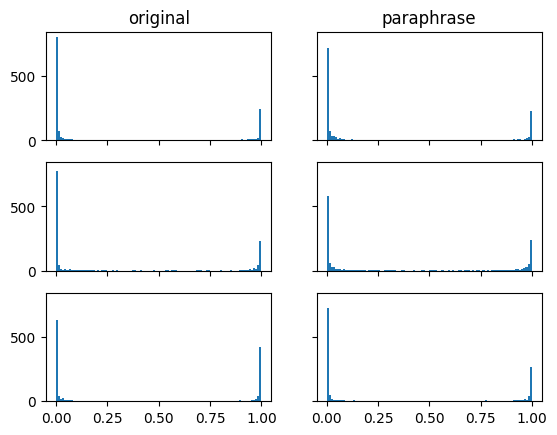

In [13]:
# histogram of columns prob_pos_org, prob_neu_org, prob_neg_org, prob_pos_new, prob_neu_new, prob_neg_new
import matplotlib.pyplot as plt

# figure with 3 subplots
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)
axs[0, 0].hist(df['prob_pos_org'], bins=100)
axs[0, 0].set_title('original')
axs[0, 1].hist(df['prob_pos_new'], bins=100)
axs[0, 1].set_title('paraphrase')
axs[1, 0].hist(df['prob_neu_org'], bins=100)
axs[1, 1].hist(df['prob_neu_new'], bins=100)
axs[2, 0].hist(df['prob_neg_org'], bins=100)
axs[2, 1].hist(df['prob_neg_new'], bins=100)
plt.show()



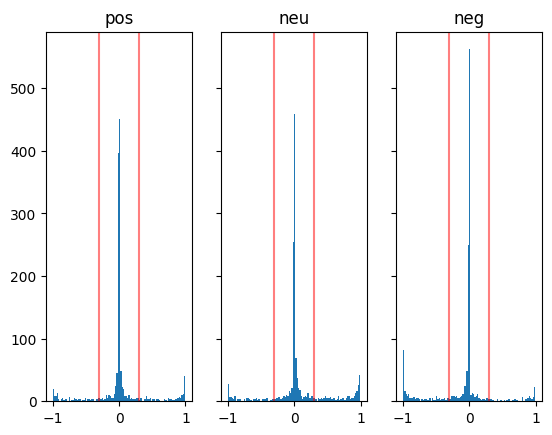

In [14]:
# plot the difference between the probabilities
df['diff_pos'] = df['prob_pos_new'] - df['prob_pos_org']
df['diff_neu'] = df['prob_neu_new'] - df['prob_neu_org']
df['diff_neg'] = df['prob_neg_new'] - df['prob_neg_org']

# figure with 3 subplots
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
axs[0].hist(df['diff_pos'], bins=100)
axs[0].set_title('pos')
axs[1].hist(df['diff_neu'], bins=100)
axs[1].set_title('neu')
axs[2].hist(df['diff_neg'], bins=100)
axs[2].set_title('neg')
# line at -0.3 and 0.3
axs[0].axvline(x=-0.3, color='r', alpha=0.5)
axs[0].axvline(x=0.3, color='r', alpha=0.5)
axs[1].axvline(x=-0.3, color='r', alpha=0.5)
axs[1].axvline(x=0.3, color='r', alpha=0.5)
axs[2].axvline(x=-0.3, color='r', alpha=0.5)
axs[2].axvline(x=0.3, color='r', alpha=0.5)
plt.show()


In [15]:
# size of difference above absolute 0.3
print('pos', len(df[df['diff_pos'].abs() > 0.3]))
print('pos', len(df[df['diff_pos'].abs() < 0.3]))
print('neu', len(df[df['diff_neu'].abs() > 0.3]))
print('neu', len(df[df['diff_neu'].abs() < 0.3]))
print('neg', len(df[df['diff_neg'].abs() > 0.3]))
print('neg', len(df[df['diff_neg'].abs() < 0.3]))



pos 301
pos 1147
neu 396
neu 1052
neg 364
neg 1084


In [16]:
# create a new column with the predicted tone_new
df['tone_new'] = df[['prob_pos_new', 'prob_neu_new', 'prob_neg_new']].idxmax(axis=1)
df['tone_new'] = df['tone_new'].apply(lambda x: x.split('_')[1])
df['tone_org'] = df[['prob_pos_org', 'prob_neu_org', 'prob_neg_org']].idxmax(axis=1)
df['tone_org'] = df['tone_org'].apply(lambda x: x.split('_')[1])
# print(df['tone_new'].value_counts())
# print(df['tone_org'].value_counts())
# print(df['label'].value_counts())

# change tone to 'positive' and 'negative' and 'neutral'
df['tone_new'] = df['tone_new'].apply(lambda x: 'positive' if x == 'pos' else x)
df['tone_new'] = df['tone_new'].apply(lambda x: 'negative' if x == 'neg' else x)
df['tone_new'] = df['tone_new'].apply(lambda x: 'neutral' if x == 'neu' else x)

df['tone_org'] = df['tone_org'].apply(lambda x: 'positive' if x == 'pos' else x)
df['tone_org'] = df['tone_org'].apply(lambda x: 'negative' if x == 'neg' else x)
df['tone_org'] = df['tone_org'].apply(lambda x: 'neutral' if x == 'neu' else x)

# compare predicted with label
df['correct_org'] = df['tone_org'] == df['label']
print('% correct for org data: ', df['correct_org'].value_counts()/len(df))
df['correct_new'] = df['tone_new'] == df['label']
print('% correct for new data: ', df['correct_new'].value_counts()/len(df))

# filter out semantic semilarity below 0.7 and above 0.95 in a new dataframe
df_filtered = df[(df['semantic_similarity'] > 0.7) & (df['semantic_similarity'] < 0.95)].copy()
# compare predicted with label
df_filtered['correct_org'] = df_filtered['tone_org'] == df_filtered['label']
print('% correct for filtered data org: ', df_filtered['correct_org'].value_counts()/len(df_filtered))
df_filtered['correct_new'] = df_filtered['tone_new'] == df_filtered['label']
print('% correct for filtered data new: ', df_filtered['correct_new'].value_counts()/len(df_filtered))


% correct for org data:  correct_org
True     0.700276
False    0.299724
Name: count, dtype: float64
% correct for new data:  correct_new
True     0.602901
False    0.397099
Name: count, dtype: float64
% correct for filtered data org:  correct_org
True     0.722459
False    0.277541
Name: count, dtype: float64
% correct for filtered data new:  correct_new
True     0.622545
False    0.377455
Name: count, dtype: float64


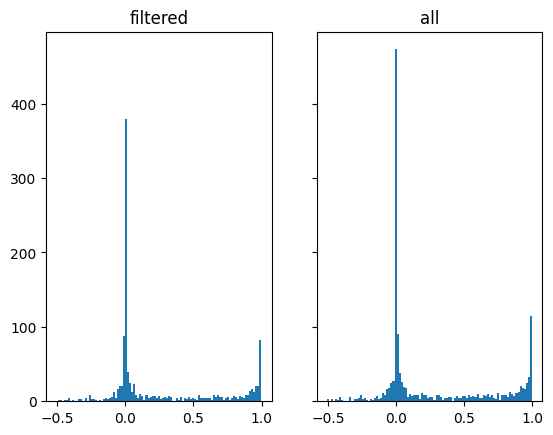

In [17]:
# difference betweeen highest propability in org and the corresponding probability in new
df_filtered['probabilities_para_argmax'] = df_filtered['probabilities_text'].apply(lambda x: x.argmax())
df_filtered['selected_probability'] = df_filtered.apply(lambda row: row['probabilities_para'][int(row['probabilities_para_argmax'])], axis=1)
df_filtered['diff_org_new'] = df_filtered['probabilities_text'].apply(lambda x: max(x)) - df_filtered['selected_probability']


# difference betweeen highest propability in org and the corresponding probability in new
df['probabilities_para_argmax'] = df['probabilities_text'].apply(lambda x: x.argmax())
df['selected_probability'] = df.apply(lambda row: row['probabilities_para'][int(row['probabilities_para_argmax'])], axis=1)
df['diff_org_new'] = df['probabilities_text'].apply(lambda x: max(x)) - df['selected_probability']

# make two histograms of the differences
# figure with 3 subplots
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].hist(df_filtered['diff_org_new'], bins=100)
axs[0].set_title('filtered')
axs[1].hist(df['diff_org_new'], bins=100)
axs[1].set_title('all')
plt.show()

In [18]:
# filter out diff_org_new below -0.3 and above 0.3 in a new dataframe
df_filtered_sent = df_filtered[(df_filtered['diff_org_new'] > -0.3) & (df_filtered['diff_org_new'] < 0.3)].copy()

In [14]:
# # using librari textdescriptives to calculate readability and coherence
# import textdescriptives as td

# # will automatically download the relevant model (´en_core_web_lg´) and extract all metrics
# df_text_qua = td.extract_metrics(text=df['text_paraphrase_clean'], lang="da", metrics=["quality"])

In [20]:
import spacy
import dacy

nlp = spacy.blank("da")  # an empty spacy pipeline
# could also be a dacy pipeline, e.g. nlp = dacy.load("large")
nlp.add_pipe("dacy/polarity")
docs = nlp.pipe(df['text_paraphrase_clean'])

nlp = spacy.blank("da")  # an empty spacy pipeline
# could also be a dacy pipeline, e.g. nlp = dacy.load("large")
nlp.add_pipe("dacy/polarity")
docs = nlp.pipe(df['text_paraphrase_clean'])

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [48]:
nlp = spacy.blank("da")  # an empty spacy pipeline
# could also be a dacy pipeline, e.g. nlp = dacy.load("large")
nlp.add_pipe("dacy/polarity")
docs = list(nlp.pipe(df['text_paraphrase_clean'][0:10]))

prob_list = []

for doc in docs:
    # print the model predictions
    prob_list.append(doc._.polarity_prob['prob'])

In [53]:
docs = list(nlp.pipe(df['text_paraphrase_clean']))

prob_list = []

for doc in docs:
    # print the model predictions
    prob_list.append(doc._.polarity_prob['prob'])

df['polarity_prob'] = prob_list

In [51]:
df['probabilities_text'] = df['text'].apply(lambda x: list(nlp.pipe(x))[0]._.polarity_prob['prob'])

KeyboardInterrupt: 

In [49]:
# add columns with probabilities
df['probabilities_text'] = df['text'].apply(lambda x: nlp.predict_proba(x, analytic=False)[0])
df[['prob_pos_org', 'prob_neu_org', 'prob_neg_org']] = pd.DataFrame(df.probabilities_text.tolist(), index= df.index)
df['probabilities_para'] = df['text_paraphrase_clean'].apply(lambda x: classifier.predict_proba(x, analytic=False)[0])
df[['prob_pos_new', 'prob_neu_new', 'prob_neg_new']] = pd.DataFrame(df.probabilities_para.tolist(), index= df.index)

[array([0.   , 0.001, 0.998], dtype=float32),
 array([0.071, 0.929, 0.001], dtype=float32),
 array([0.588, 0.409, 0.002], dtype=float32),
 array([0.006, 0.989, 0.006], dtype=float32),
 array([0.001, 0.998, 0.001], dtype=float32),
 array([0.   , 0.001, 0.998], dtype=float32),
 array([0.326, 0.671, 0.003], dtype=float32),
 array([0.016, 0.983, 0.001], dtype=float32),
 array([0.003, 0.996, 0.001], dtype=float32),
 array([0.001, 0.001, 0.999], dtype=float32)]

In [33]:
list(docs)

[]